In [1]:
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from IPython.display import clear_output, display
from torch.utils.data import TensorDataset, DataLoader


$\frac{\partial T}{\partial t} - \frac{{\partial}^2 T}{\partial x^2} = 0$

$ T(t, x) = 2 + e^{-4 \pi^2 t} sin(2\pi x) + e^{-16\pi^2 t} cos(4\pi x)$, $x\in[0,1], t\in[0, 0.05]$

$\\$$T_0 = T(0, x) = 2 + sin(2\pi x) + cos(4\pi x)$

$ T(t, 0) = T(t, 1) = 2 + e^{-16\pi^2 t}$

In [2]:
def thermal_conductivity_equation(x):
    return (2 + torch.exp(-4*(torch.pi**2)*x[0])*torch.sin(2*torch.pi*x[1]) + torch.exp(-16*(torch.pi**2)*x[0])*torch.cos(4*torch.pi*x[1]))

def check_current_situation(cur_model, t=0):
    x = torch.linspace(0, 1, 100)
    time = t * torch.ones(100)
    real_temp = thermal_conductivity_equation([time, x])

    test_points = torch.stack((time, x), axis = -1)

    pinn_temp = cur_model(test_points)

    plt.plot(x.detach(), pinn_temp.cpu().detach(), label=f'PINN prediction with t = {t}')
    plt.plot(x, real_temp, label=f'Analytical solution with t = {t}')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel(f'T(t={t}, x)')

    plt.plot()
    plt.legend()
    plt.show()

In [3]:
DEVICE = 'cpu'

In [4]:
# x_50 = torch.rand(50).requires_grad_(True).to(DEVICE)
# t_50 = 0.05 * torch.rand(50).requires_grad_(True).to(DEVICE)
# torch.save(x_50, 'x_50.pt')
# torch.save(t_50, 't_50.pt')

# x_100 = torch.rand(100).requires_grad_(True).to(DEVICE)
# t_100 = 0.05 * torch.rand(100).requires_grad_(True).to(DEVICE)
# torch.save(x_100, 'x_100.pt')
# torch.save(t_100, 't_100.pt')

# x_200 = torch.rand(200).requires_grad_(True).to(DEVICE)
# t_200 = 0.05 * torch.rand(200).requires_grad_(True).to(DEVICE)
# torch.save(x_200, 'x_200.pt')
# torch.save(t_200, 't_200.pt')

# x_500 = torch.rand(500).requires_grad_(True).to(DEVICE)
# t_500 = 0.05 * torch.rand(500).requires_grad_(True).to(DEVICE)
# torch.save(x_500, 'x_500.pt')
# torch.save(t_500, 't_500.pt')

# x_1000 = torch.rand(1000).requires_grad_(True).to(DEVICE)
# t_1000 = 0.05 * torch.rand(1000).requires_grad_(True).to(DEVICE)
# torch.save(x_1000, 'x_1000.pt')
# torch.save(t_1000, 't_1000.pt')

# x_5000 = torch.rand(5000).requires_grad_(True).to(DEVICE)
# t_5000 = 0.05 * torch.rand(5000).requires_grad_(True).to(DEVICE)
# torch.save(x_5000, 'x_5000.pt')
# torch.save(t_5000, 't_5000.pt')

In [24]:
# 200 500 1_000 5_000
N = 50

In [25]:
x_physics = torch.load(f'data/x_{N}.pt').requires_grad_(True).to(DEVICE)
time_physics = torch.load(f'data/t_{N}.pt').requires_grad_(True).to(DEVICE)

In [26]:
# x_physics = torch.rand(N).requires_grad_(True).to(DEVICE)
# time_physics = 0.05 * torch.rand(N).requires_grad_(True).to(DEVICE)
points_for_pinn_model = torch.stack((time_physics, x_physics), -1).to(DEVICE)
boundary_condition_points = torch.stack((torch.zeros(N).to(DEVICE), x_physics), -1).to(DEVICE)
periodic_points_x0 = torch.stack((time_physics, torch.zeros(N).to(DEVICE)), -1).to(DEVICE)
periodic_points_x1 = torch.stack((time_physics, torch.ones(N).to(DEVICE)), -1).to(DEVICE)

In [27]:
# class PINN(nn.Module):
#     def __init__(self, input_dim=2, hidden_dim=128, num_layers=16, output_dim=1):
#         super().__init__()

#         self.input_layer = nn.Linear(input_dim, hidden_dim)
#         self.hidden_layers = nn.ModuleList(
#             [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers)]
#         )
#         self.output_layer = nn.Linear(hidden_dim, output_dim)

#         self._init_weights()

#     def _init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_uniform_(m.weight)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)

#     def forward(self, x):
#         h = torch.relu(self.input_layer(x))
#         for i, layer in enumerate(self.hidden_layers):
#             h_new = torch.relu(layer(h))
#             if i % 2 == 1:
#                 h = h + h_new
#             else:
#                 h = h_new
#         T = self.output_layer(h)
#         return T
# class PINN(nn.Module):
#     def __init__(self, input_layer = 2, hidden_layer = 32, number_layers = 6, output_layer = 1):
#         super().__init__()
        
#         self.activation1 = nn.ReLU
#         self.activation2 = nn.ReLU()
        
#         self.fcs = nn.Sequential(*
#             [
#                 nn.Linear(input_layer, hidden_layer),
#                 self.activation1()
#             ]
#         )
        
#         self.fch = nn.Sequential(*
#             [
#                 nn.Sequential(*
#                     [
#                         nn.Linear(hidden_layer, hidden_layer),
#                         self.activation1()
#                     ]
#                 ) for _ in range(number_layers - 1)
#             ]
#         )
        
#         self.fce = nn.Linear(hidden_layer, output_layer)
#         self._initialize_weights()

#     def _initialize_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.xavier_normal_(m.weight, gain=1.0)
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)
        
#     def forward(self, x):
#         x = self.fcs(x)
#         x = self.fch(x)
#         x = self.fce(x)
#         x = self.activation2(x)
#         return x
class PINN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, num_layers=4, output_dim=1):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.U = nn.Linear(input_dim, hidden_dim)
        self.V = nn.Linear(input_dim, hidden_dim)

        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_layers - 1)]
        )

        self.output_layer = nn.Linear(hidden_dim, output_dim)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        U = torch.tanh(self.U(x))
        V = torch.tanh(self.V(x))

        h = U * V

        for i, layer in enumerate(self.hidden_layers):
            h_new = torch.relu(layer(h))
            if i % 2 == 1 and i > 0:
                h = h + h_new
            else:
                h = h_new

        T = self.output_layer(h)
        return T

In [28]:
def flat_the_gradient_from_loss(model, loss):
    grads = torch.autograd.grad(
        loss,
        list(model.parameters()),
        retain_graph=True,
        allow_unused=True
    )
    flat = []
    for p, g in zip(model.parameters(), grads):
        if g is None:
            flat.append(torch.zeros(p.numel(), device=p.device))
        else:
            flat.append(g.detach().reshape(-1))
    return torch.cat(flat).cpu().numpy()
def orthogonalize(v1, v2):
    dot = np.dot(v1, v2)
    proj = dot / (np.dot(v1, v1) + 1e-6) * v1
    return v2 - proj

def compute_weights_grad_orthogonal_autograd(model, loss_ic, loss_pde, loss_data, kappa=5.0, eps=1e-6):
    grad_ic   = flat_the_gradient_from_loss(model, loss_ic)
    grad_pde  = flat_the_gradient_from_loss(model, loss_pde)
    grad_data = flat_the_gradient_from_loss(model, loss_data)

    grad_pde_orth = orthogonalize(grad_ic, grad_pde)
    grad_data_orth = orthogonalize(grad_ic, grad_data)
    grad_data_orth = orthogonalize(grad_pde_orth, grad_data_orth)

    lv_ic = loss_ic.detach().cpu().numpy()
    lv_pde = loss_pde.detach().cpu().numpy()
    lv_data = loss_data.detach().cpu().numpy()

    w_ic = 1.0
    w_pde = np.exp(-kappa * lv_ic) * np.linalg.norm(grad_pde_orth)
    w_data = np.exp(-kappa * max(lv_ic, lv_pde)) * np.linalg.norm(grad_data_orth)
    w_sum = w_ic + w_pde + w_data + eps
    w_ic /= w_sum
    w_pde /= w_sum
    w_data /= w_sum

    return w_ic, w_pde, w_data

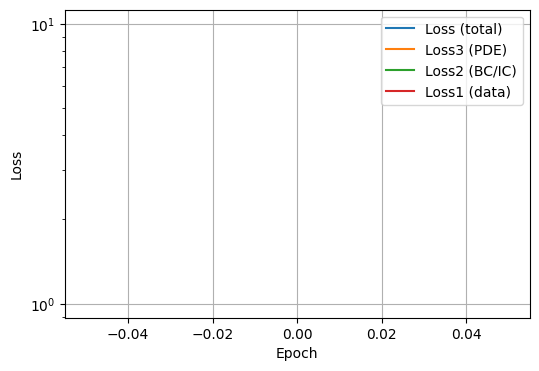

In [29]:
pinn_model = PINN().to(DEVICE)
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.003)
loss_history = []

epochs_hist = []
loss_hist   = []
loss1_hist  = []
loss2_hist  = []
loss3_hist  = []

fig, ax = plt.subplots(figsize=(6, 4))

(line_loss,)  = ax.plot([], [], label="Loss (total)")
(line_l3,)    = ax.plot([], [], label="Loss3 (PDE)")
(line_l2,)    = ax.plot([], [], label="Loss2 (BC/IC)")
(line_l1,)    = ax.plot([], [], label="Loss1 (data)")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.grid(True)
ax.legend()

def update_loss_plot(epoch, loss, loss1, loss2, loss3):
    # store history
    epochs_hist.append(epoch)
    loss_hist.append(loss.cpu().detach().numpy())
    loss1_hist.append(loss1.cpu().detach().numpy())
    loss2_hist.append(loss2.cpu().detach().numpy())
    loss3_hist.append(loss3.cpu().detach().numpy())

    # update line data
    line_loss.set_data(epochs_hist, loss_hist)
    line_l1.set_data(epochs_hist, loss1_hist)
    line_l2.set_data(epochs_hist, loss2_hist)
    line_l3.set_data(epochs_hist, loss3_hist)

    # rescale
    ax.relim()
    ax.autoscale_view()

    clear_output(wait=True)
    display(fig)

  0%|          | 0/20000 [00:00<?, ?it/s]

epoch: 0	loss: (0.0008775444002822042, 0.0006481164018623531, 8.054077625274658e-05, 0.00014888722216710448)	
0.20760429 0.4141315 0.3782638 

epoch: 250	loss: (0.0007857379969209433, 0.0007101495284587145, 5.2376464736880735e-05, 2.3212011001305655e-05)	
0.31007951 0.5976995 0.09222032 

epoch: 500	loss: (0.000779631722252816, 0.0005809646681882441, 0.00017600171850062907, 2.2665308279101737e-05)	
0.27605817 0.69567424 0.028266922 

epoch: 750	loss: (0.0007287269691005349, 0.0005173224490135908, 0.00012143770436523482, 8.996683754958212e-05)	
0.13635261 0.51649266 0.34715426 

epoch: 1000	loss: (0.0032464079558849335, 0.0006586509407497942, 0.0004785381315741688, 0.00210921885445714)	
0.08244939 0.19126435 0.72628605 

epoch: 1250	loss: (0.0009168275282718241, 0.000618338817730546, 6.805497832829133e-05, 0.00023043371038511395)	
0.24303143 0.4773104 0.2796578 

epoch: 1500	loss: (0.0006706894491799176, 0.0005163097521290183, 0.00011533444921951741, 3.904525874531828e-05)	
0.19656782 0

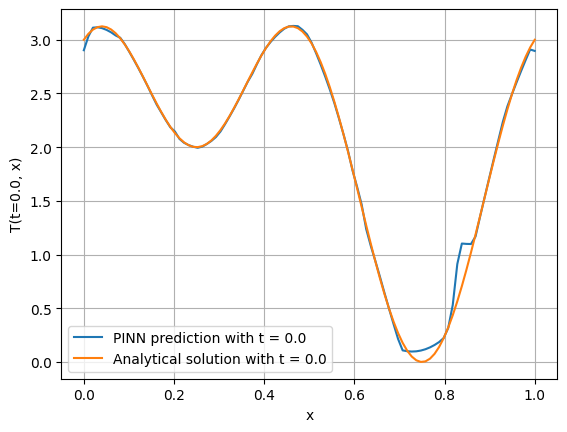

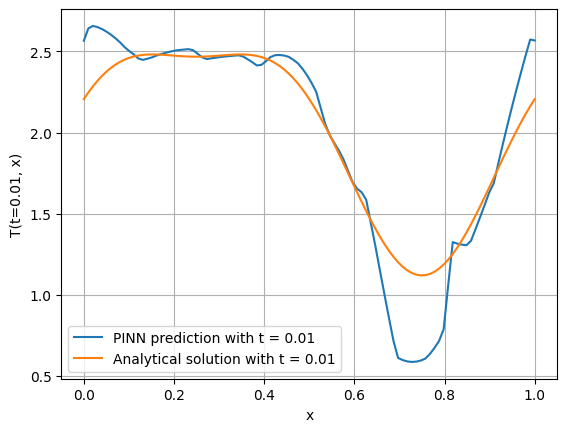

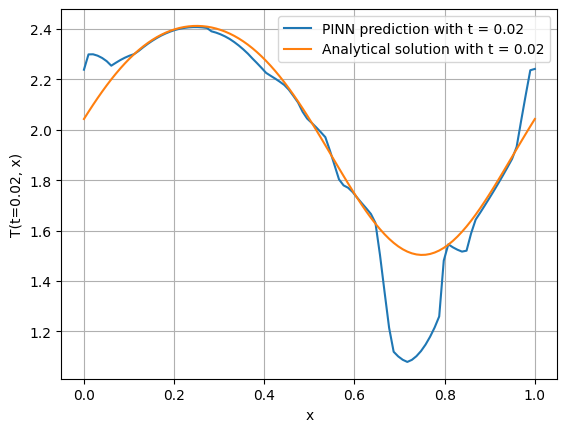

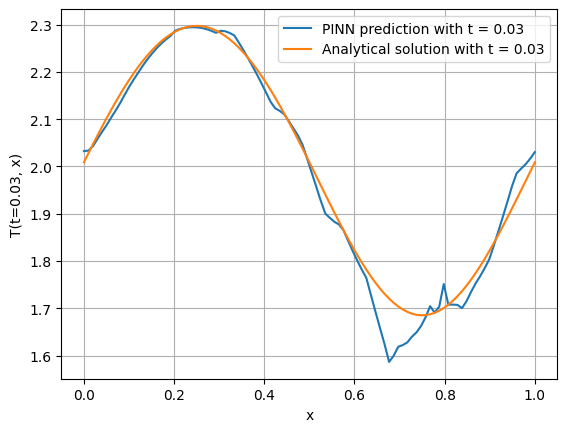

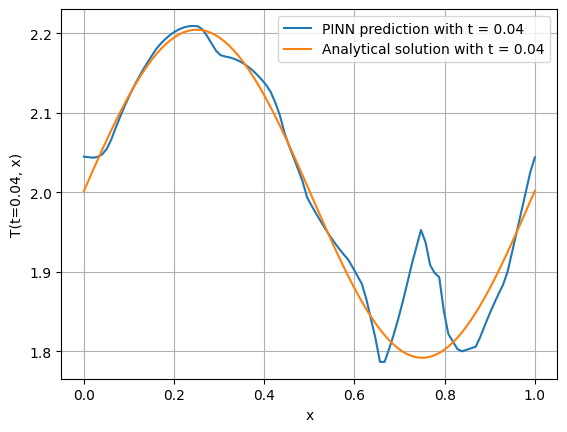

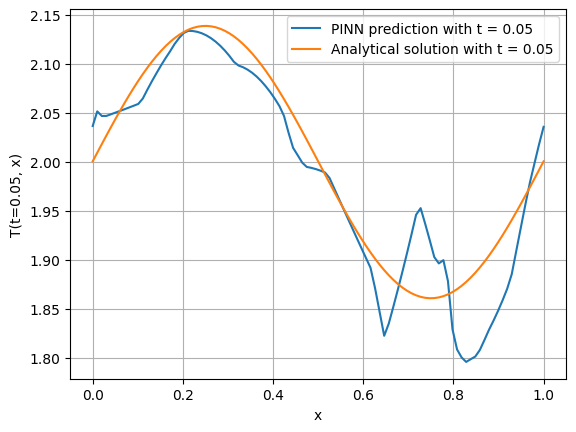

epoch: 3000	loss: (0.000723616685718298, 0.0005814426112920046, 9.491683158557862e-05, 4.7257213736884296e-05)	
0.30100757 0.605922 0.09306988 

epoch: 3250	loss: (0.0007698750705458224, 0.0005088982870802283, 0.0002107177278958261, 5.025903374189511e-05)	
0.24635722 0.6255046 0.12813762 

epoch: 3500	loss: (0.0006326275761239231, 0.0004823898780159652, 9.740735549712554e-05, 5.28303389728535e-05)	
0.1538429 0.5999489 0.24620762 

epoch: 3750	loss: (0.0008577617118135095, 0.0006795150111429393, 0.00011400299263186753, 6.424366438295692e-05)	
0.20168222 0.5596085 0.23870873 

epoch: 4000	loss: (0.0006324013811536133, 0.0005511912168003619, 4.440230259206146e-05, 3.680786176119e-05)	
0.29733804 0.6460004 0.056660976 

epoch: 4250	loss: (0.000688292842824012, 0.0005240515456534922, 0.00012710779265034944, 3.713350452017039e-05)	
0.2807929 0.63844955 0.08075698 

epoch: 4500	loss: (0.001129446434788406, 0.0005110065103508532, 9.586361557012424e-05, 0.0005225763306953013)	
0.15277669 0.3288

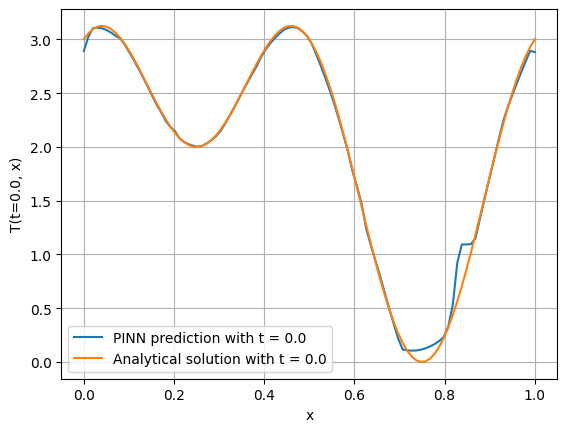

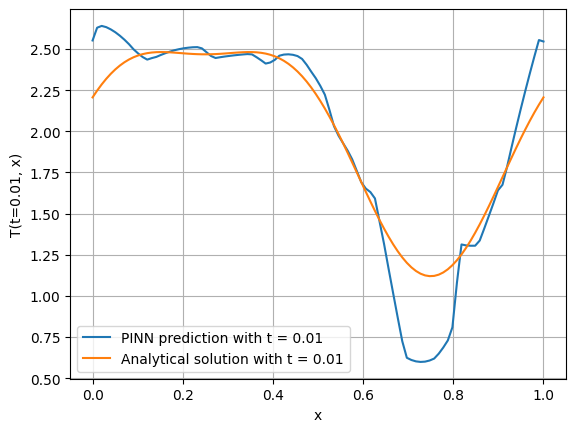

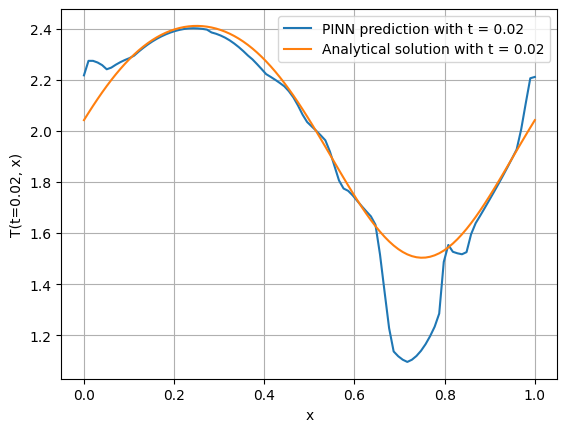

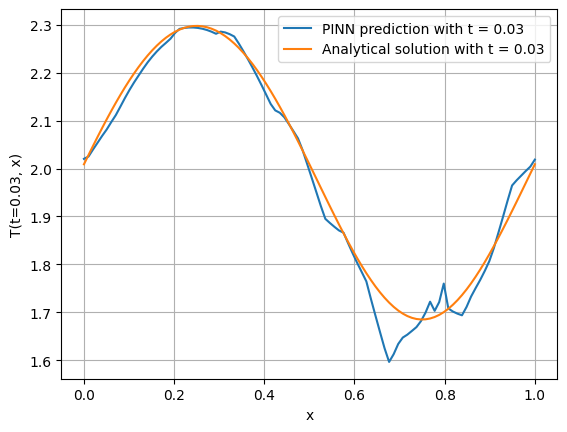

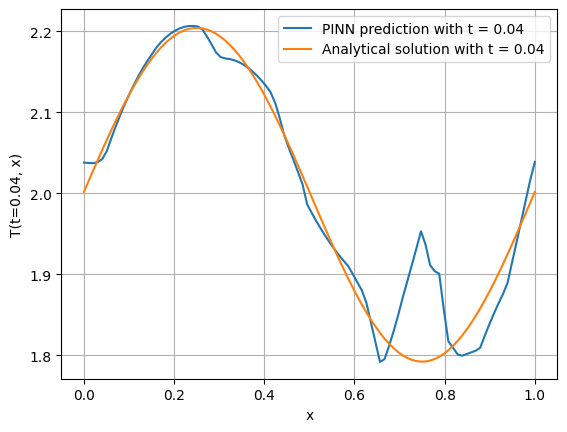

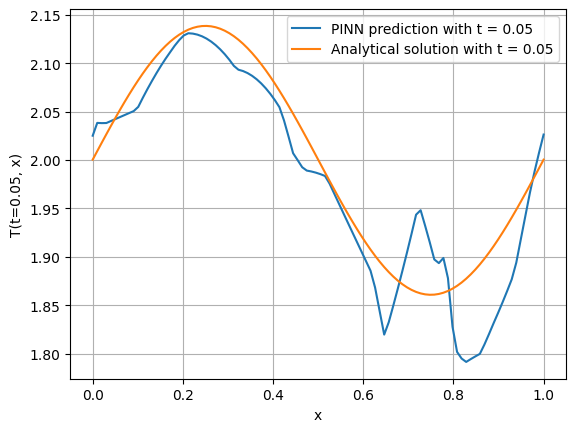

epoch: 6000	loss: (0.0008095429511740804, 0.00043662023381330073, 0.00022889100364409387, 0.000144031728268601)	
0.1370725 0.47978753 0.38313958 

epoch: 6250	loss: (0.0005491492920555174, 0.00037766119930893183, 0.0001338954025413841, 3.759265746339224e-05)	
0.06735708 0.77627397 0.1563683 

epoch: 6500	loss: (0.0005784420645795763, 0.000488516699988395, 6.25386310275644e-05, 2.738676266744733e-05)	
0.28642583 0.6399879 0.07358574 

epoch: 6750	loss: (0.0005296875606290996, 0.00045349932042881846, 4.657592944568023e-05, 2.961233985843137e-05)	
0.25817072 0.7042516 0.03757709 

epoch: 7000	loss: (0.0005618716240860522, 0.00047817255835980177, 4.4811753468820825e-05, 3.888733408530243e-05)	
0.28555706 0.6545993 0.05984297 

epoch: 7250	loss: (0.0005678106099367142, 0.0004665393498726189, 6.947323709027842e-05, 3.1798055715626106e-05)	
0.2336371 0.6300825 0.13627987 

epoch: 7500	loss: (0.004298636224120855, 0.0010242745047435164, 0.0006280317902565002, 0.002646329812705517)	
0.06183531 

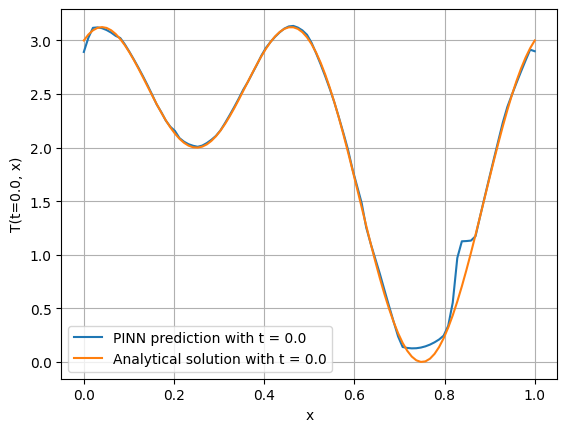

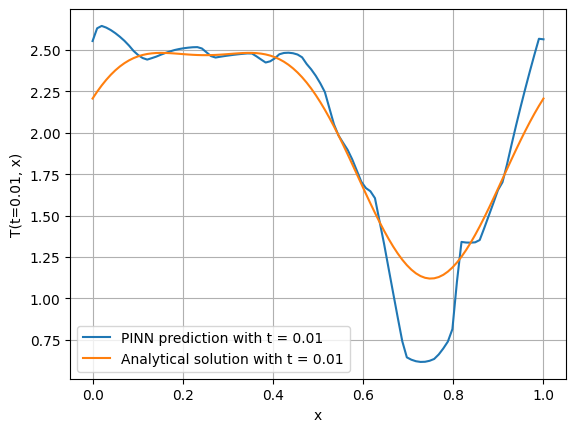

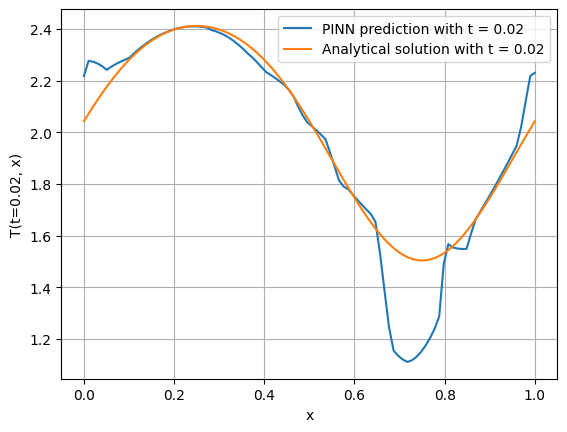

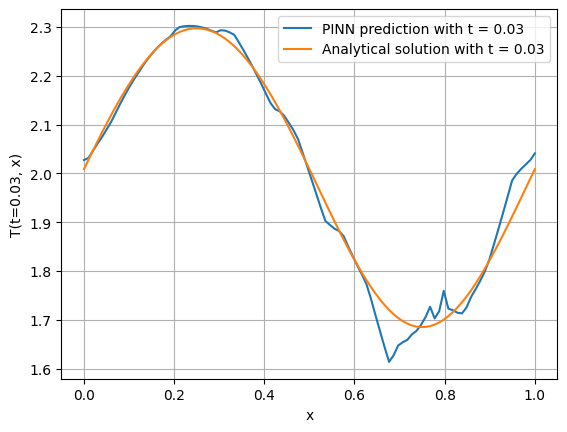

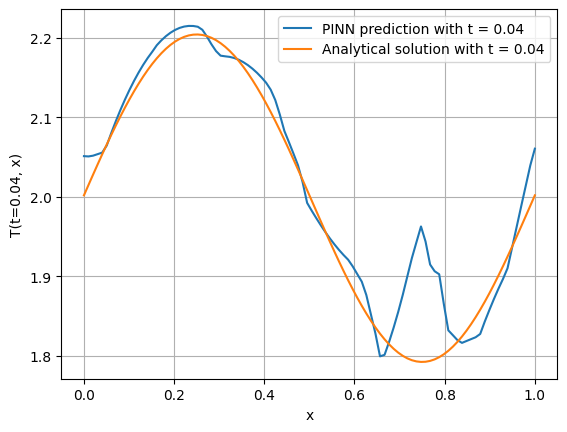

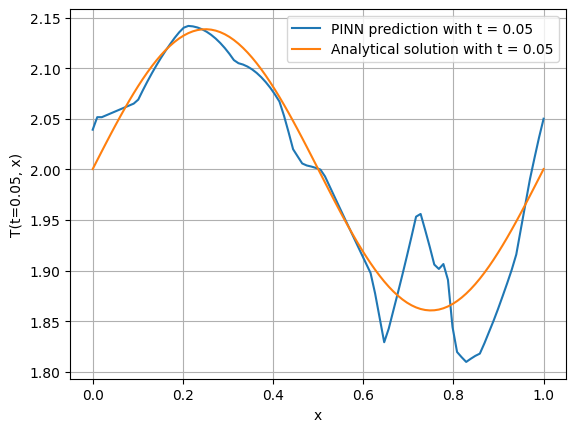

epoch: 9000	loss: (0.002526744268834591, 0.00047460876521654427, 0.001173853874206543, 0.0008782816003076732)	
0.08708254 0.28022256 0.6326946 

epoch: 9250	loss: (0.00048318749759346247, 0.00037784187588840723, 7.826634828234091e-05, 2.707927706069313e-05)	
0.06692696 0.8821551 0.050917126 

epoch: 9500	loss: (0.0005346991238184273, 0.0004705341998487711, 3.413387094042264e-05, 3.003107303811703e-05)	
0.25072312 0.68108547 0.06819076 

epoch: 9750	loss: (0.0006212808657437563, 0.00042122192098759115, 4.88171681354288e-05, 0.00015124178025871515)	
0.17176795 0.48214376 0.3460878 

epoch: 10000	loss: (0.000690644548740238, 0.0005537660326808691, 7.966833800310269e-05, 5.7210145314456895e-05)	
0.10877077 0.5682173 0.3230114 

epoch: 10250	loss: (0.0005254928837530315, 0.0003361549461260438, 0.0001559051452204585, 3.343277785461396e-05)	
0.14187485 0.6922551 0.16586936 

epoch: 10500	loss: (0.0008326055249199271, 0.0005403104587458074, 0.00022648680896963924, 6.580822810065001e-05)	
0.225

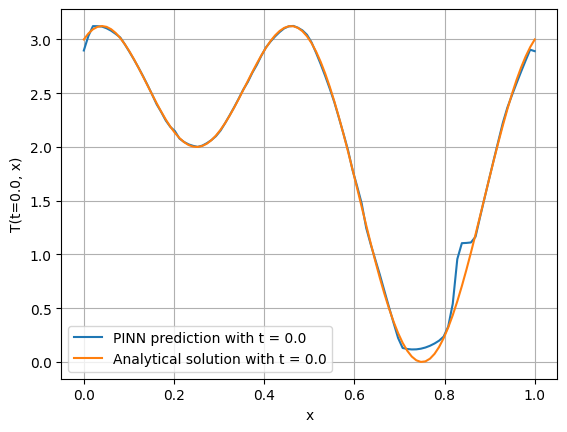

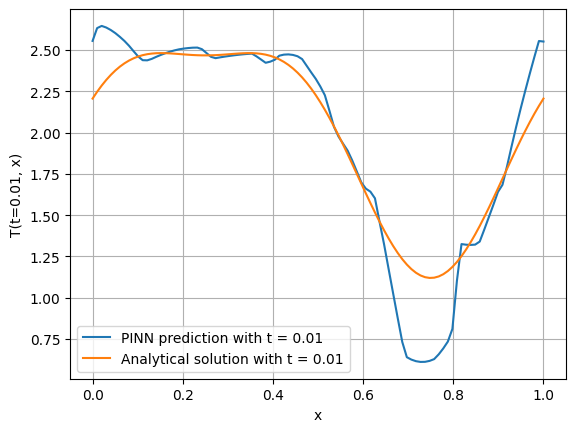

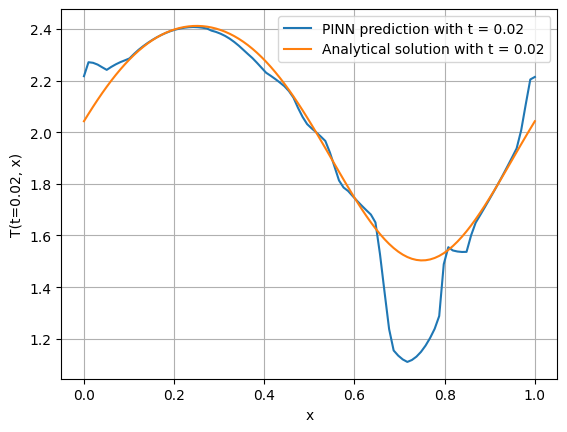

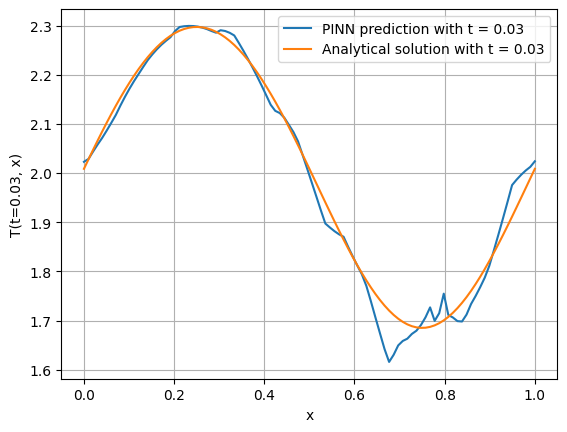

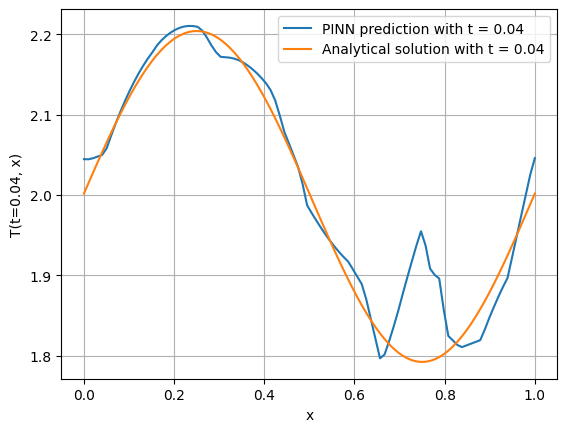

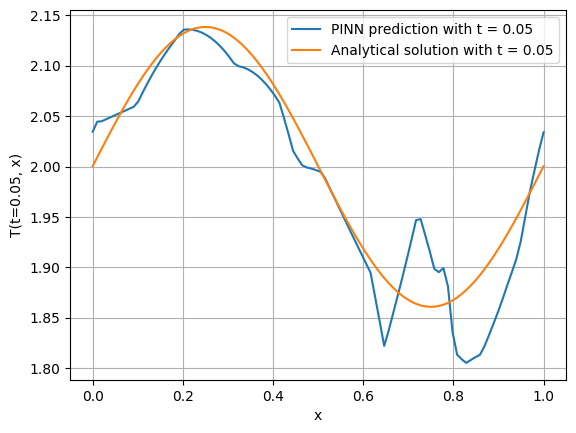

epoch: 12000	loss: (0.0004849122487939894, 0.0004128165601287037, 3.378276960575022e-05, 3.831290814559907e-05)	
0.23735696 0.69901687 0.06362549 

epoch: 12250	loss: (0.0004671617643907666, 0.0004212561179883778, 2.9044873372185975e-05, 1.686079485807568e-05)	
0.2130079 0.7136805 0.07331089 

epoch: 12500	loss: (0.0005249868263490498, 0.00045568111818283796, 2.8101181669626385e-05, 4.120453741052188e-05)	
0.16608644 0.6376593 0.19625361 

epoch: 12750	loss: (0.0005003396654501557, 0.00044759150478057563, 2.9938528314232826e-05, 2.2809652364230715e-05)	
0.22229801 0.72863126 0.049070075 

epoch: 13000	loss: (0.0004041531356051564, 0.0003479567531030625, 3.852340887533501e-05, 1.7672995454631746e-05)	
0.07735839 0.7933903 0.1292506 

epoch: 13250	loss: (0.0004700142308138311, 0.0003343124408274889, 0.00011728135723387823, 1.8420421838527545e-05)	
0.17787378 0.73629856 0.08582696 

epoch: 13500	loss: (0.0004509916470851749, 0.00038368627429008484, 3.8935897464398295e-05, 2.83694826066494

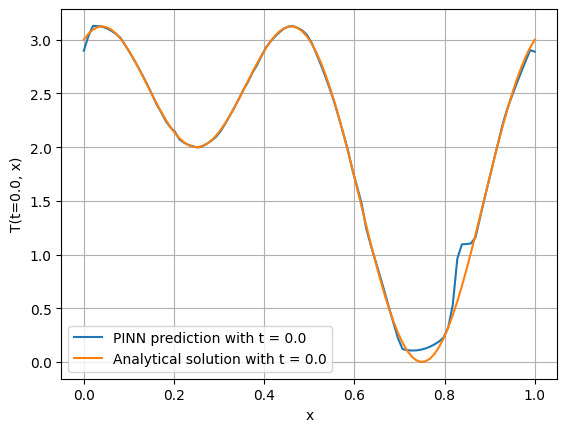

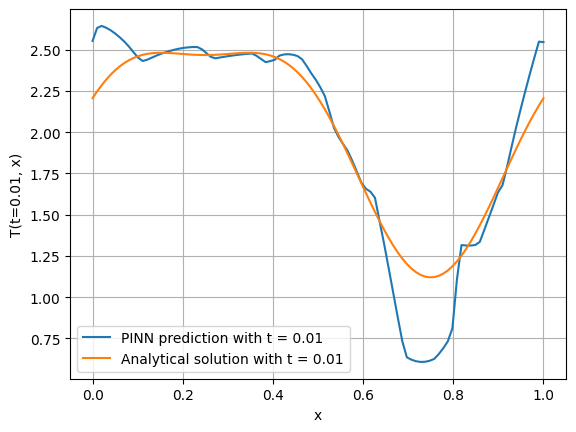

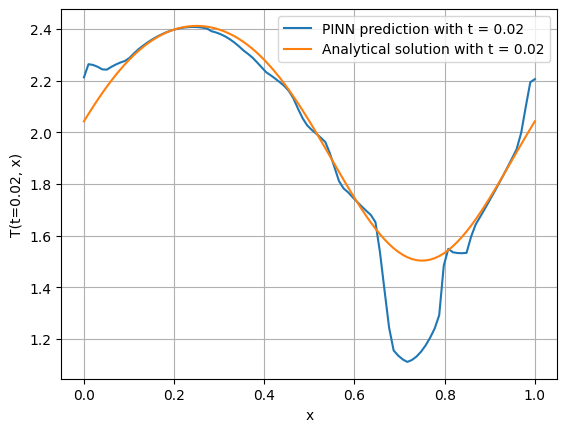

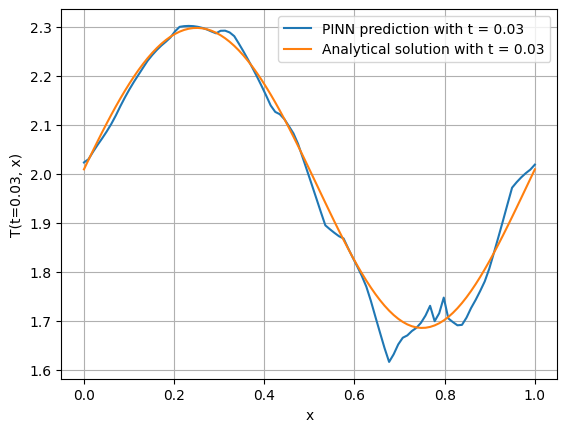

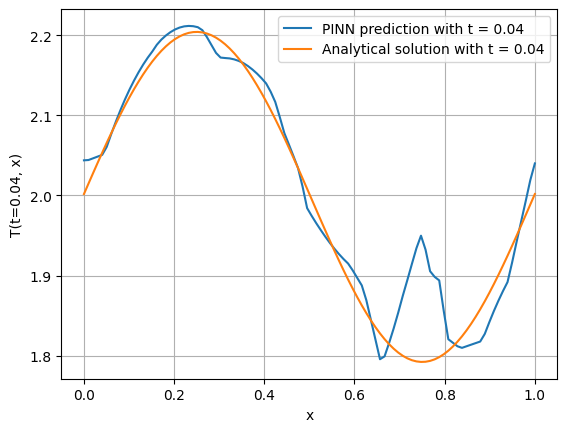

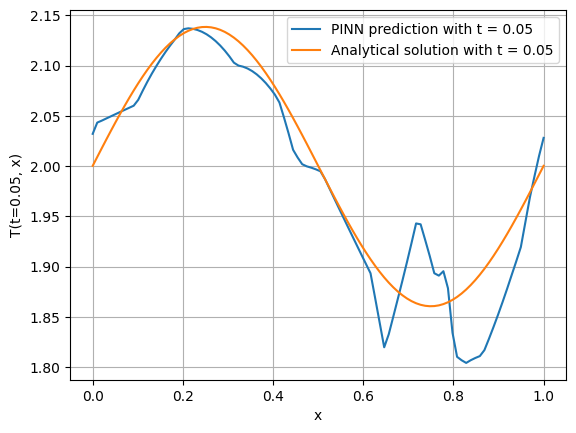

epoch: 15000	loss: (0.00044768190127797425, 0.00035056535853073, 7.944937533466145e-05, 1.7667167412582785e-05)	
0.18899731 0.6819073 0.1290948 

epoch: 15250	loss: (0.0006454014801420271, 0.00036998919676989317, 6.411547656171024e-05, 0.00021129682136233896)	
0.14747038 0.4012316 0.4512976 

epoch: 15500	loss: (0.00043235949124209583, 0.00040136073948815465, 1.6387873984058388e-05, 1.4610885045840405e-05)	
0.1343586 0.8251399 0.04050072 

epoch: 15750	loss: (0.00043455447303131223, 0.00038957074866630137, 2.6209521820419468e-05, 1.8774200725601986e-05)	
0.21992207 0.6540342 0.12604313 

epoch: 16000	loss: (0.0007939299684949219, 0.0003494569973554462, 0.0003429956850595772, 0.00010147730790777132)	
0.15178949 0.49241415 0.35579592 

epoch: 16250	loss: (0.00043094553984701633, 0.00040711663314141333, 1.5309222362702712e-05, 8.519669790985063e-06)	
0.217431 0.7446046 0.037963703 

epoch: 16500	loss: (0.0003947402292396873, 0.00035743211628869176, 2.27709133469034e-05, 1.453718596167164e

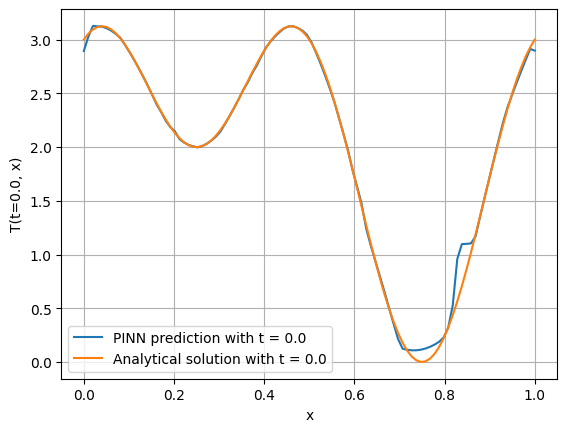

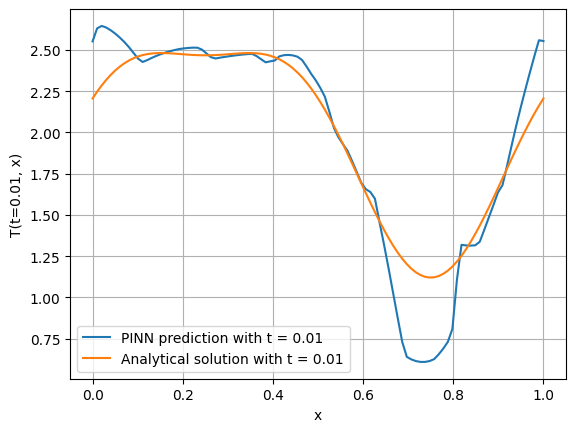

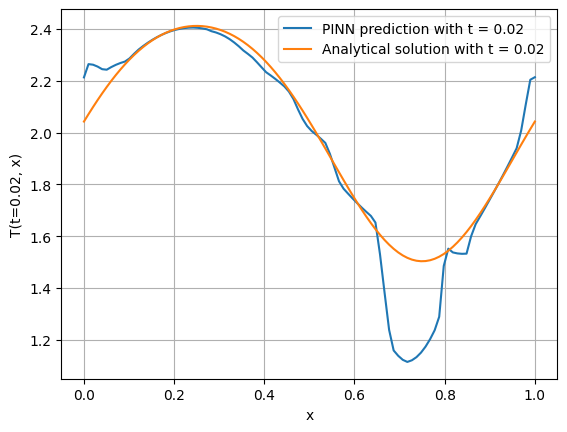

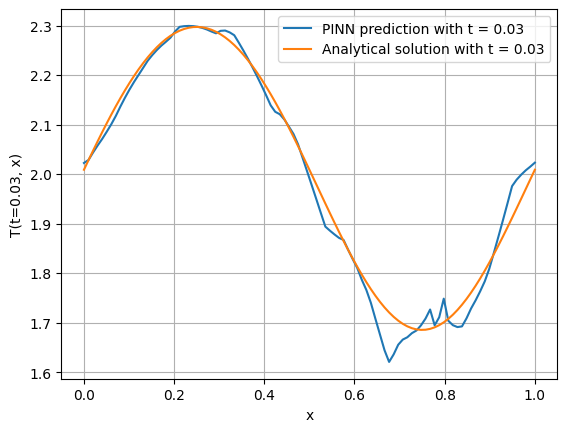

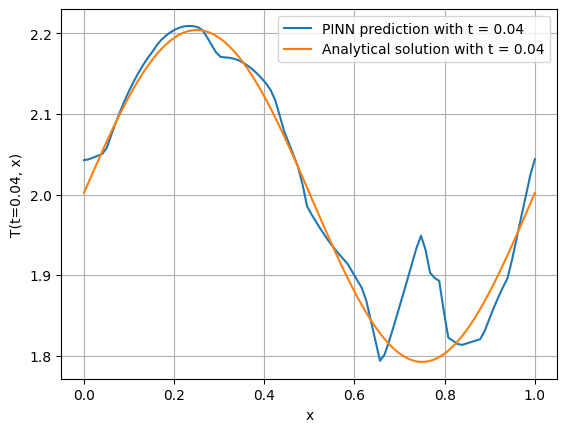

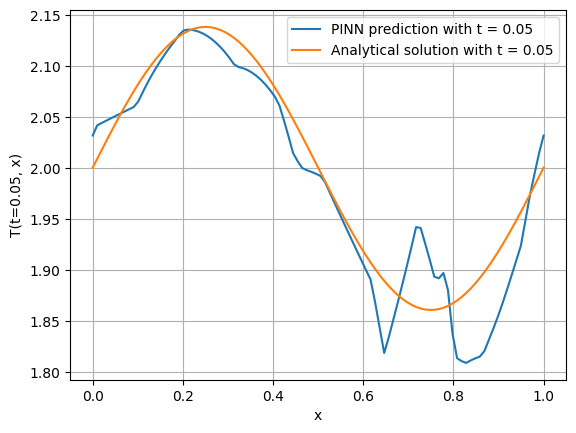

epoch: 18000	loss: (0.00040092383278533816, 0.00034044860512949526, 3.7753594369860366e-05, 2.2721609639120288e-05)	
0.06763501 0.78247494 0.14988934 

epoch: 18250	loss: (0.0004288434865884483, 0.00038875231985002756, 1.7132400898844935e-05, 2.295876583957579e-05)	
0.22231485 0.7220851 0.05559934 

epoch: 18500	loss: (0.00038632741780020297, 0.0003519922902341932, 2.17571432585828e-05, 1.257798430742696e-05)	
0.08785227 0.83724225 0.0749047 

epoch: 18750	loss: (0.0004145890998188406, 0.0003869388601742685, 1.5258861822076142e-05, 1.2391396012390032e-05)	
0.17266 0.7827922 0.04454701 

epoch: 19000	loss: (0.0003747478767763823, 0.0003346074663568288, 2.641870560182724e-05, 1.3721690265811048e-05)	
0.05919223 0.89939535 0.04141152 

epoch: 19250	loss: (0.0004307715280447155, 0.00038889338611625135, 2.0996103557990864e-05, 2.0882025637547486e-05)	
0.18584116 0.7617654 0.052392684 

epoch: 19500	loss: (0.00038755746209062636, 0.00031790274078957736, 5.2810562920058146e-05, 1.684416565694

In [32]:
epochs = 20_000
loss_prev = None
for cur_epoch in trange(epochs):
    
    optimizer.zero_grad()
    
    boundary_condition_temp = pinn_model(boundary_condition_points)
    network_temp = pinn_model(points_for_pinn_model)
    periodic_temp_0 = pinn_model(periodic_points_x0)
    periodic_temp_1 = pinn_model(periodic_points_x1)
    
    loss1 = torch.mean(
        (thermal_conductivity_equation([time_physics, x_physics]).view(-1,1) - network_temp)**2
    )
    
    loss2 = torch.mean(
        (thermal_conductivity_equation([torch.zeros_like(time_physics), x_physics]).view(-1,1) - boundary_condition_temp)**2 +
        (periodic_temp_0 - periodic_temp_1)**2
    )

    network_temp = pinn_model(points_for_pinn_model)
    
    dt = torch.autograd.grad(network_temp, time_physics, torch.ones_like(network_temp), create_graph=True, allow_unused=False)[0]
    dx = torch.autograd.grad(network_temp, x_physics, torch.ones_like(network_temp), create_graph=True, allow_unused=False)[0]
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True, allow_unused=False)[0]

    
    loss3 = torch.mean((dt - dx2)**2)
    dist = loss1+loss2+loss3

    w2, w3, w1 = compute_weights_grad_orthogonal_autograd(
        pinn_model, loss2, loss3, loss1, kappa=3.0, eps=1e-6
    )

    loss = w1*loss1 + w2*loss2 + w3*loss3
    
    loss.backward(retain_graph=True)
    loss_history.append(float(dist.cpu().detach().numpy()))
    torch.nn.utils.clip_grad_norm_(pinn_model.parameters(), max_norm=1.0)
    optimizer.step()
    dist = loss1 + loss2 + loss3
    # update_loss_plot(cur_epoch, loss, loss1, loss2, loss3)
    if loss_prev == None or loss_prev >= loss:
        torch.save(pinn_model.state_dict(), f'pinn_model_weights_{N}.pth')
    if cur_epoch % 3_000  == 0 and cur_epoch != 0:
        optimizer.param_groups[0]['lr'] *= 0.9
        check_current_situation(pinn_model, t=0.0)
        check_current_situation(pinn_model, t=0.01)
        check_current_situation(pinn_model, t=0.02)
        check_current_situation(pinn_model, t=0.03)
        check_current_situation(pinn_model, t=0.04)
        check_current_situation(pinn_model, t=0.05)
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss: {float(dist.cpu().detach().numpy()), float(loss1.cpu().detach().numpy()), float(loss2.cpu().detach().numpy()), float(loss3.cpu().detach().numpy())}\t')
        print(w1, w2, w3,'\n')

In [33]:
print(f'pinn_model_weights_{N}')
print(x_physics.shape)

pinn_model_weights_50
torch.Size([50])


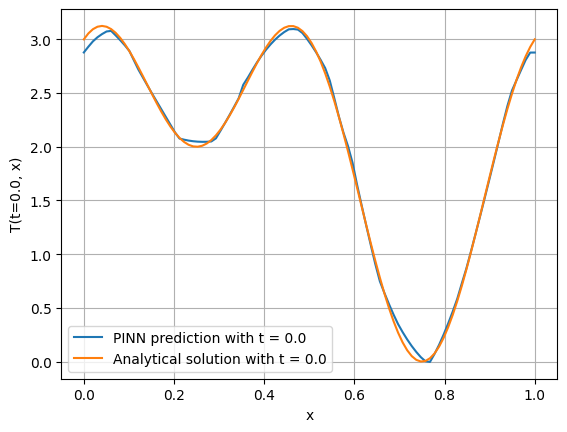

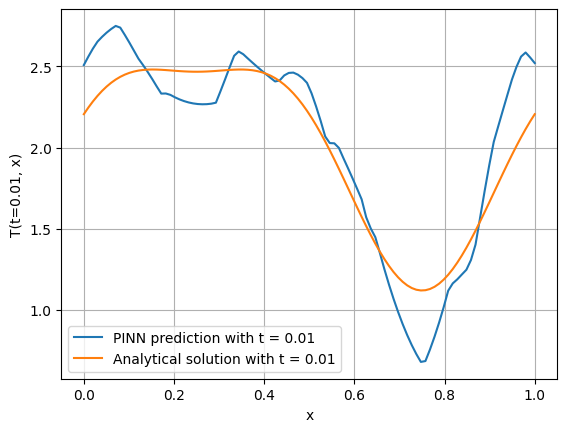

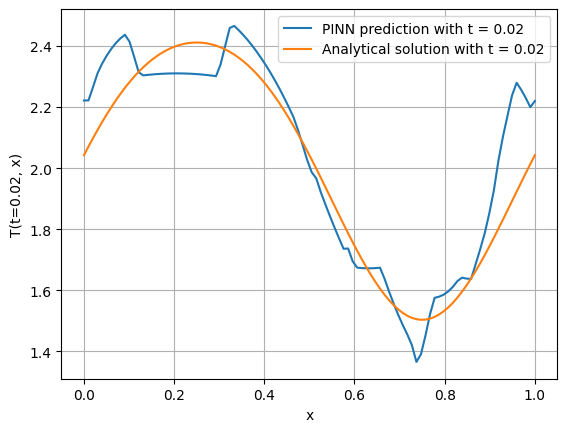

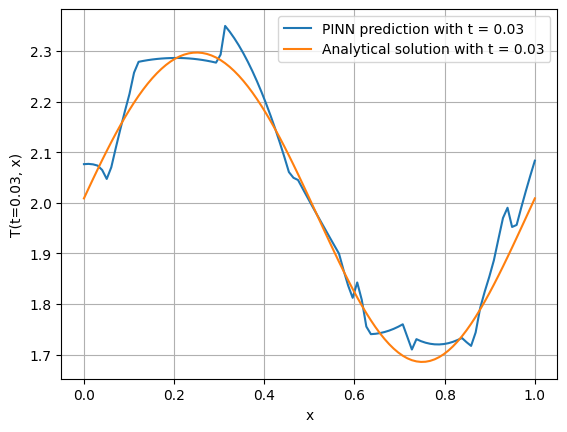

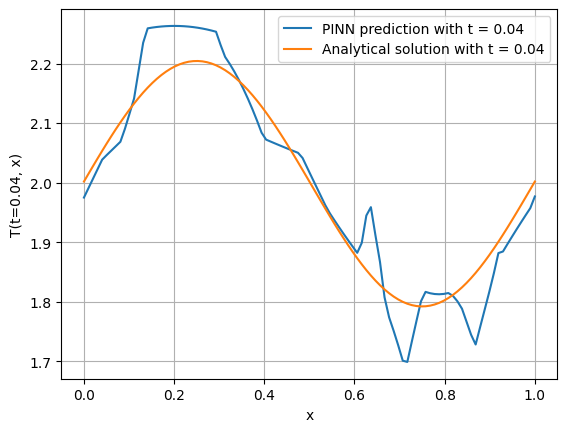

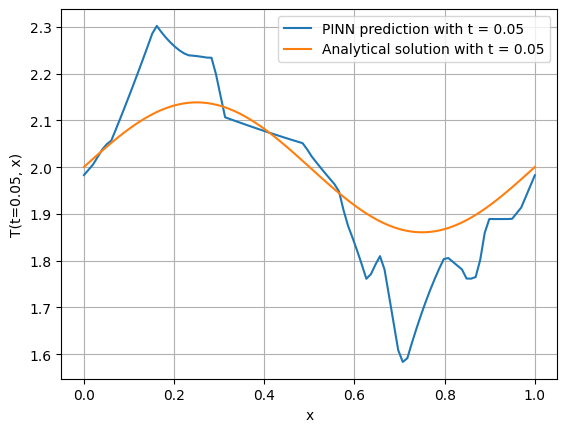

In [16]:
check_current_situation(pinn_model, t=0.0)
check_current_situation(pinn_model, t=0.01)
check_current_situation(pinn_model, t=0.02)
check_current_situation(pinn_model, t=0.03)
check_current_situation(pinn_model, t=0.04)
check_current_situation(pinn_model, t=0.05)

In [15]:
x_physics.shape

torch.Size([5000])

# SVM

In [16]:
def check_current_situation_svm(svm_model, scaler, t=0):
    x = np.linspace(0, 1, 100)
    time = t * np.ones(100)
    real_temp = thermal_conductivity_equation([torch.tensor(time), torch.tensor(x)])

    test_points = np.stack((time, x), axis = -1)

    svm_pred = svm_model.predict(scaler.transform(test_points))

    plt.plot(x, svm_pred, label=f'SVM prediction with t = {t}')
    plt.plot(x, real_temp, label=f'Analytical solution with t = {t}')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel(f'T(t={t}, x)')

    plt.plot()
    plt.legend()
    plt.show()

In [19]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

x_svm = x_physics.cpu().detach().numpy()
time_svm = time_physics.cpu().detach().numpy()

X_train = points_for_pinn_model.cpu().detach().numpy()
y_train = thermal_conductivity_equation([points_for_pinn_model[:, 0], points_for_pinn_model[:, 1]]).cpu().detach().numpy()

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

svr = SVR(kernel="rbf", C=1.0, epsilon=0.1, gamma="scale")

svr.fit(X_train_scaled, y_train)
# y_pred = svr.predict(X_test_scaled)
# print("MSE:", mean_squared_error(y_test, y_pred))
# print("R^2:", r2_score(y_test, y_pred))

SVR()

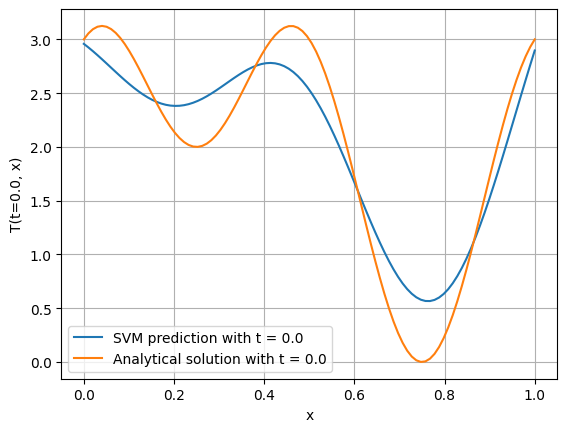

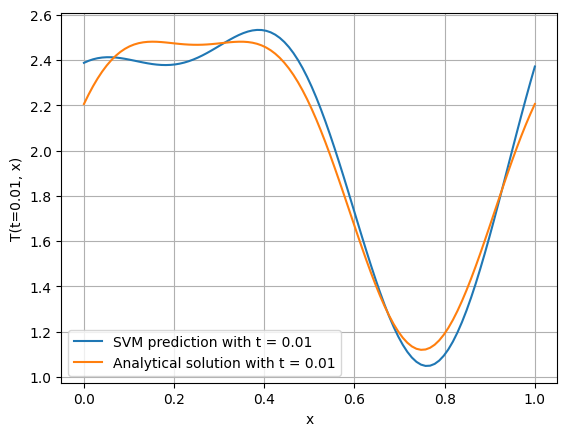

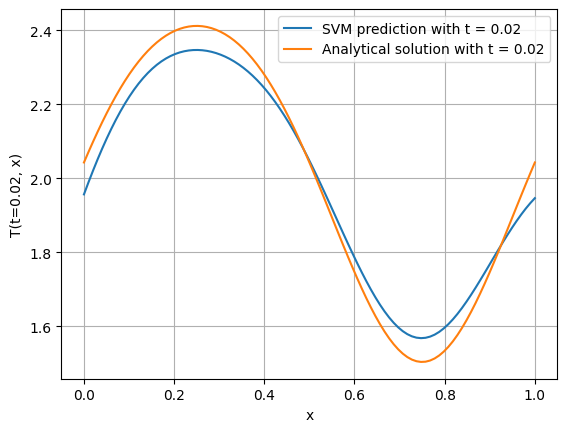

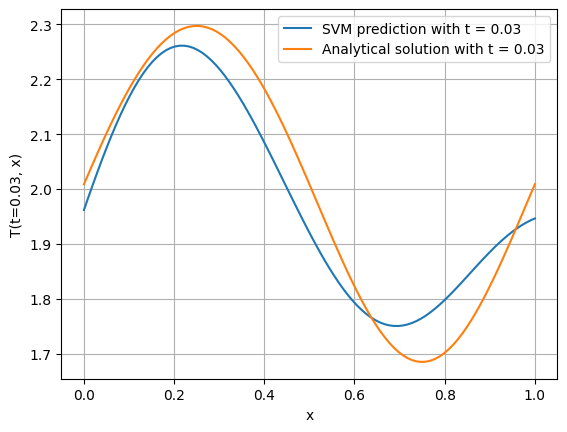

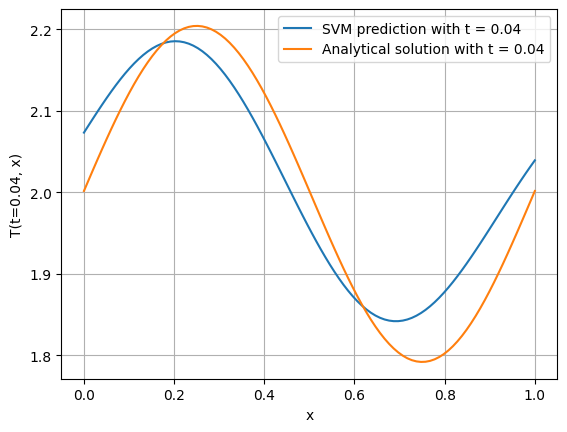

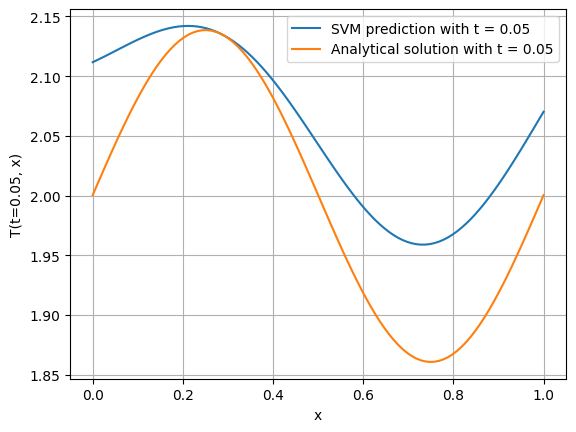

In [20]:
check_current_situation_svm(svr, scaler, t=0.0)
check_current_situation_svm(svr, scaler, t=0.01)
check_current_situation_svm(svr, scaler, t=0.02)
check_current_situation_svm(svr, scaler, t=0.03)
check_current_situation_svm(svr, scaler, t=0.04)
check_current_situation_svm(svr, scaler, t=0.05)